<a id="top"></a>
# LUVex Aperture Generation Notebook

This notebook is used to generate hexagonal segmented apertures. 


## Package imports

In [1]:
#%matplotlib qt
import os
os.chdir('../..')
%matplotlib inline
from hcipy import *
from aplc_optimization.Inputs_Generation.SCDA_Inputs_Generation import make_SCDA_hex_aperture
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import math

## Defining Aperture/LS generation functions

Aperture generation function catered to the LUVex test apertures:

In [23]:
def make_LUVex_test_aperture(normalized=True, num_rings=6, clipped=False, pupil_diameter=7.9445, 
                             pupil_inscribed = 6.0023, with_segment_gaps=True, gap_padding=0, 
                             segment_transmissions=1, return_header=False, return_segments=False):
    '''Make a hexagonal segmented aperture with no secondary obstruction/support structures.
    
    Parameters
    ----------
    normalized : boolean
        If this is True, the pupil diameter will be scaled to 1.
    with_segment_gaps : boolean
        Include the gaps between individual segments in the aperture.
    gap_padding : scalar
        Arbitrary padding of gap size to represent gaps on smaller arrays - effectively makes the gaps larger and 
        the segments smaller to preserve the same segment pitch.
    num_rings : int
        The number of rings of hexagons to include, not counting the central segment. Default is 6.
    clipped : bool
        Remove corner segments and increase individual segment size to maximize the telescope geometry to render it 
        as circular a possible. 
    segment_transmissions : scalar or array_like
        The transmission for each of the segments. If this is a scalar, this transmission will be used for all 
        segments.
    return_header : boolean
        Return header with all important values for the created aperture, for reference.
    return_segments : boolean
        Reutrn the segments as a ModeBasis.
    Returns
    -------
    aperture : Field generator
        The LUVex test aperture.
    aperture_header : dict
        Dictionary containing all quantities used when making this aperture. Only returned if `return_header` is True.
    segments : list of Field generators
        The segments. Only returned when `return_segments` is True.
    '''
    num_segments = 3 * num_rings * (num_rings + 1) + 1 # number of segments, including the central segment
    actual_segment_gap = 0.006                         #m: gap size between segments
    segment_gap = actual_segment_gap * gap_padding     # padding out segmentation gaps so they are visible and not sub-pixel
    
    if not with_segment_gaps:
        segment_gap = 0
    
    actual_pupil_diameter = pupil_diameter 
    
    if clipped and num_rings > 2: 
        num_segments = num_segments-6  #subtract the 6 ommitted corner segments
        actual_segment_flat_diameter = (pupil_inscribed - 2*(num_rings-1)*segment_gap) / (2*(num_rings-1)+1)
        
        # circumscribed diameter of the aperture if unclipped, for normalization. 
        pupil_diameter = actual_segment_flat_diameter * (2*num_rings+1) + 2*num_rings*segment_gap
    else:
        actual_segment_flat_diameter = (pupil_diameter - 2*num_rings*segment_gap) / (2*num_rings+1)
        
        
    segment_flat_diameter = actual_segment_flat_diameter - (segment_gap - actual_segment_gap)
    segment_circum_diameter = 2 / np.sqrt(3) * segment_flat_diameter  # segment circumscribed diameter
    
    aperture_header = {'TELESCOP': 'SCDA', 'D_CIRC': actual_pupil_diameter, 'D_INSC': pupil_inscribed,
                        'SEG_F2F_D': actual_segment_flat_diameter, 'SEG_GAP': actual_segment_gap, 'GAP_PAD':gap_padding,
                        'NORM': normalized, 'SEG_TRAN': segment_transmissions, 
                        'NUM_RINGS': num_rings, 'CLIPPED': clipped, 'NUM_SEG': num_segments}

    if normalized:
        segment_circum_diameter /= pupil_diameter
        segment_flat_diameter /= pupil_diameter
        segment_gap /= pupil_diameter
        pupil_diameter = 1.0

    segment_positions = make_hexagonal_grid(segment_flat_diameter + segment_gap, num_rings)

    if clipped:
        segment_positions = segment_positions.subset(circular_aperture(pupil_diameter * 0.85))
        
    segment = hexagonal_aperture(segment_circum_diameter, np.pi / 2)
    segmented_aperture = make_segmented_aperture(segment, segment_positions, segment_transmissions,
                                                 return_segments=return_segments)

    if return_segments:
        segmented_aperture, segments = segmented_aperture

    def func(grid):
        res = segmented_aperture(grid)

        return Field(res, grid)

    if return_header:
        if return_segments:
            return func, aperture_header, segments
        else:
            return func, aperture_header
    elif return_segments:
        return func, segments
    else:
        return


Function generate a Lyot stop slightly undersized to the inscribed pupil diameter.

In [24]:
def make_a_lyot_stop(normalized=False, pupil_diameter=7.9445, pupil_inscribed = 6.0023,
                     inner_diameter_fraction=0.2, outer_diameter_fraction=0.9, return_header=False):
    """Make a Lyot stop for the APLC coronagraph.

    Parameters
    ----------
    normalized : boolean
        If this is True, the pupil diameter will be scaled to 1. Otherwise, the
        diameter of the pupil will be 15.0 meters.
    pupil_diameter : scalar
        The circumscribed pupil diameter.
    pupil_inscribed : scalar
        The inscribed pupil diameter.
    inner_diameter_fraction : scalar
        The fractional size of the lyot stop inner diameter(s) as a fraction of the inscribed circle diameter.
    outer_diameter_fraction : scalar
        The fractional size of the lyot stop outer diameter(s) as a fraction of the inscribed circle diameter.
    return_header : boolean
        Return header giving all important values for the created Lyot stop mask, for reference.

    Returns
    -------
    lyot_stop : Field generator
        A field generator for the Lyot stop.
    header : dict
        A dictionary containing all important values for the created Lyot stop mask. Only returned if `return_header` is True.
    """
    outer_D = pupil_inscribed * outer_diameter_fraction
    inner_D = pupil_inscribed * inner_diameter_fraction
    
    lyot_reference_diameter = pupil_inscribed

    ls_header = {'TELESCOP':'LUVOIR A', 'D_CIRC': pupil_diameter, 'D_INSC': pupil_inscribed,
                 'LS_ID': inner_diameter_fraction, 'LS_OD': outer_diameter_fraction, 
                 'LS_REF_D': lyot_reference_diameter, 'NORM': normalized}
    
    if normalized:
        outer_D /= pupil_diameter
        inner_D /= pupil_diameter
        
    outer_diameter = circular_aperture(outer_D)
    central_obscuration = circular_aperture(inner_D)

    def aper(grid):
        result = outer_diameter(grid) - central_obscuration(grid)

        return result

    if return_header:
        return aper, ls_header

    return aper

# Setting Parameters

In [4]:
filepath = 'masks/SCDA/'
N        = 1024  # number of pixels in aperture, lyot stop, apodizer array
oversamp = 4     # oversampling factor in evaluate_supersampled [hcipy/field/util.py]. 
                 # if set to 1 returns bw pupil. For gray set to > 1, nominally set to 4 (4 grey levels)
gap_padding = 1  # gap padding factor

In [5]:
num_rings = 4    # number of rings of hexagons N around the central segment

Circumscribed and inscribed pupil diameters based on the pupil files provided by GSFC. 

In [6]:
pup_diams = [[7.9445, 6.0023],  # Hex-1
             [7.2617, 5.9994],  # Hex-2
             [7.7231, 5.9899],  # Hex-3
             [7.1522, 5.9937],  # Hex-4
             [6.8526, 5.9941]]  # Hex-5

#Get the corresponding diameters from the number of rings.
pupil_diameter, pupil_diameter_inscribed = pup_diams[num_rings-1] 

## Aperture parameters
Segmented pupil composed of hexagonal segments distributed over `num_rings` rings around the central
segment. 

In [7]:
#oversampling factor, black and white or grey pixels
if oversamp == 1:
    edge = 'bw'
elif oversamp > 1:
    edge = 'gy'

The 'clipped' flag, allows for the outer corner segments of the pupil to me omitted, to maximize the telescope geometry to render it as circular as possible and maximizing the diameter of the inscribed circle with respect to the overall diameter.

In [26]:
clipped = True  # whether to omit outer segments to form a more circular aperture

num_segments = 3*num_rings*(num_rings+1)+1
if clipped:
    num_segments = num_segments-6

print('Segmented pupil composed of {0} hexagonal segments distributed over {1} rings around the central segment.'.format(num_segments, num_rings))

Segmented pupil composed of 55 hexagonal segments distributed over 4 rings around the central segment.


## Lyot Stop parameters

In [9]:
lyot_ref_diam = pupil_diameter_inscribed # diameter used to reference LS id and od against

The Lyot stop inner diameter is set to 0 to remove central obstruction.

In [25]:
LS_ID = [0]     # Lyot stop inner diameter(s), relative to inscribed circle, re-normalized against circumscribed pupil in LS gen function
LS_OD = [0.982] # Lyot stop outer diameter, relative to inscribed circle, re-normalized against circumscribed pupil in LS gen function

# Construct aperture, write to fits

In [35]:
if clipped:
    pup_filename = 'TelAp_LUVex1_{0:02d}-Hex_{1:s}_clipped_ovsamp{2:02d}__N{3:04d}.fits'.format(num_rings,edge,oversamp,N)
else:
    pup_filename = 'TelAp_LUVex1_{0:02d}-Hex_{1:s}_ovsamp{2:02d}__N{3:04d}.fits'.format(num_rings,edge,oversamp,N)

grid                     = make_pupil_grid(N)
HEX_ap, aperture_header  = make_LUVex_test_aperture(normalized=True, clipped = clipped, num_rings=num_rings, 
                                                    return_header = True, gap_padding=gap_padding, 
                                                    with_segment_gaps=True,
                                                    pupil_diameter=pupil_diameter, 
                                                    pupil_inscribed=pupil_diameter_inscribed)
pupil                       = evaluate_supersampled(HEX_ap,grid,oversamp)

aperture_header['OVERSAMP'] = oversamp
aperture_header['EDGE']     = edge
aperture_header['D_INSC']   = pupil_diameter_inscribed
hdr = fits.Header()
hdr.set('TELESCOP', aperture_header['TELESCOP'])
hdr.set('D_CIRC', aperture_header['D_CIRC'],'m: circumscribed diameter')
hdr.set('D_INSC', aperture_header['D_INSC'],'m: inscribed diameter')
hdr.set('SEG_F2F',aperture_header['SEG_F2F_D'],'m: actual segment flat-to-flat diameter')
hdr.set('SEG_GAP',aperture_header['SEG_GAP'],'m: actual gap size between segments')
hdr.set('NORM',aperture_header['NORM'],'normalization keyword, OD scaled to 1 by Dcirc')
hdr.set('NUM_RINGS',aperture_header['NUM_RINGS'], 'number of rings of hexagons')
hdr.set('SEG_TRAN',aperture_header['SEG_TRAN'],'transmission for each of the segments')
#hdr.set('NUM_SEG',aperture_header['NUM_SEG'],'number of hexagonal segments')
hdr.set('EDGE',aperture_header['EDGE'],'black and white, or grey pixels')
hdr.set('OVERSAMP',aperture_header['OVERSAMP'],'oversampling factor, # grey levels')

fits.writeto(filepath+pup_filename, pupil.shaped, hdr,overwrite=True)
print(filepath+pup_filename)


masks/SCDA/TelAp_LUVex1_04-Hex_gy_clipped_ovsamp04__N1024.fits


## Construct lyot stop(s), write to fits

Using knowledge of inscribed circle diameter, we can calculate the pupil diameter prior to corner segment clipping that is needed for the Lyot stop generation.

In [31]:
if clipped and num_rings > 2:
    actual_segment_gap = 0.006
    segment_gap = actual_segment_gap * gap_padding 
    actual_segment_flat_diameter = (pupil_diameter_inscribed - (2*(num_rings-1)+1)*segment_gap) / (2*(num_rings-1)+1)
    pupil_diameter = actual_segment_flat_diameter * (2*(num_rings)+1) + (2*(num_rings)+1)*segment_gap

In [32]:
for ls_id in LS_ID:
    for ls_od in LS_OD:
        
        strut_key = 'no_struts'
        ls_filename  = 'LS_LUVex2_{0:02d}-Hex_ID{1:04d}_OD{2:04d}_{3:s}_{4:s}_ovsamp{5:d}_N{6:04d}.fits'.format(num_rings, int(ls_id*1000), \
                                                                                                int(ls_od*1000), \
                                                                                                strut_key, edge, \
                                                                                                oversamp, N)

        LUVOIR_ls,ls_header = make_a_lyot_stop(normalized=True, inner_diameter_fraction=ls_id, 
                                               outer_diameter_fraction=ls_od, return_header=True, 
                                               pupil_diameter=pupil_diameter, pupil_inscribed=pupil_diameter_inscribed)
        lyot_stop = evaluate_supersampled(LUVOIR_ls, grid, oversamp)
    
        hdr = fits.Header()
        ls_header['OVERSAMP'] = oversamp
        ls_header['EDGE']     = edge
        ls_header['D_INSC']   = pupil_diameter_inscribed
    
        hdr = fits.Header()
        hdr.set('TELESCOP', ls_header['TELESCOP'])
        hdr.set('D_CIRC', ls_header['D_CIRC'],'m: circumscribed diameter')
        hdr.set('D_INSC', ls_header['D_INSC'],'m: inscribed diameter')
        hdr.set('LS_REF_D',ls_header['LS_REF_D'],'m: used to reference given LS id and od')
        hdr.set('LS_ID', ls_header['LS_ID'], 'LS inner d, fraction of LS_REF_D')
        hdr.set('LS_OD', ls_header['LS_OD'], 'LS outer d, fraction of LS_REF_D')
        hdr.set('NORM',ls_header['NORM'],'normalization keyword, OD scaled to 1 by Dcirc')
        hdr.set('EDGE',ls_header['EDGE'],'black and white, or grey pixels')
        hdr.set('OVERSAMP',ls_header['OVERSAMP'],'oversampling factor, # grey levels')
    
        fits.writeto(filepath+ls_filename, lyot_stop.shaped, hdr, overwrite=True)
        print(filepath+ls_filename)


masks/SCDA/LS_LUVex2_04-Hex_ID0000_OD0982_no_struts_gy_ovsamp4_N1024.fits


### Plot resulting Aperture and Lyot stop

(-0.49951171875, 0.49951171875, -0.49951171875, 0.49951171875)

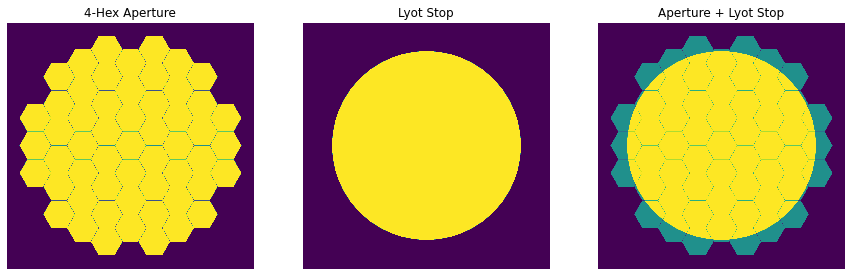

In [110]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.title('%i-Hex Aperture' %num_rings)
imshow_field(pupil)
plt.axis('off')
plt.subplot(1,3,2)
plt.title('Lyot Stop')
imshow_field(lyot_stop)
plt.axis('off')
plt.subplot(1,3,3)
plt.title('Aperture + Lyot Stop')
imshow_field(pupil+lyot_stop)
plt.axis('off')

[Top of page](#top)